In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!pip install faiss-cpu

In [17]:
!pip install PyPDF2

In [5]:
!pip install openai==0.28.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.57.4
    Uninstalling openai-1.57.4:
      Successfully uninstalled openai-1.57.4


In [24]:
import os
import zipfile
import faiss
import numpy as np
import openai
from PyPDF2 import PdfReader
from transformers import AutoTokenizer, AutoModel
import torch
from typing import List, Dict
import json

# OpenAI API 키 설정
openai.api_key = ""

# BERT 모델 로드
bert_model_name = "bert-large-uncased"  # large 버전으로 변경 (1024차원)
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
model = AutoModel.from_pretrained(bert_model_name)

In [40]:
# PDF에서 텍스트 추출 함수
def extract_text_from_pdf(pdf_path: str) -> str:
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text()
    return text

def split_into_chunks(text: str, chunk_size: int) -> List[str]:
    chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
    return chunks[:10]  # 청크 개수를 10개로 제한


def generate_bert_embedding(text: str):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy().astype('float32').flatten()

# 1536차원으로 패딩하는 함수 추가
def pad_bert_embedding(bert_embedding):
   padding_size = 1536 - len(bert_embedding)
   return np.pad(bert_embedding, (0, padding_size), 'constant')

def generate_bert_embedding(text: str):
   # Tokenize and get model outputs
   inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
   with torch.no_grad():
       outputs = model(**inputs)

   # Get CLS token embedding
   embedding = outputs.last_hidden_state[:, 0, :].numpy().flatten()

   # Pad to 1536 dimensions
   padded_embedding = pad_bert_embedding(embedding)
   return padded_embedding

# OpenAI 임베딩 생성 함수
def generate_ada_embedding(text: str, model: str = "text-embedding-ada-002") -> List[float]:
    response = openai.Embedding.create(input=text, model=model)
    return response['data'][0]['embedding']

# FAISS 인덱스 생성 함수
def create_faiss_db(dimension: int):
    return faiss.IndexFlatL2(dimension)

# FAISS 인덱스와 메타데이터 저장 함수
def save_faiss_index_with_metadata(faiss_index, metadata_store, index_path, metadata_path):
    # FAISS 인덱스 저장
    faiss.write_index(faiss_index, index_path)
    print(f"FAISS 인덱스가 {index_path}에 저장되었습니다.")

    # 메타데이터 저장
    with open(metadata_path, 'w') as f:
        json.dump(metadata_store, f)
    print(f"메타데이터가 {metadata_path}에 저장되었습니다.")

# # FAISS 검색 함수
# def search_with_faiss(embedding, faiss_index, metadata_store, k=5):
#     distances, indices = faiss_index.search(np.array([embedding]).astype('float32'), k)
#     results = [{"distance": dist, "metadata": metadata_store[idx]} for dist, idx in zip(distances[0], indices[0])]
#     return results

def search_with_faiss(embedding, faiss_index, metadata_store, k=5):
    distances, indices = faiss_index.search(np.array([embedding]).astype('float32'), k)
    results = []
    for dist, idx in zip(distances[0], indices[0]):
        if str(idx) in metadata_store:  # 메타데이터 스토어에 키가 존재하는지 확인
            results.append({"distance": dist, "metadata": metadata_store[str(idx)]})
        else:
            print(f"Warning: Index {idx} not found in metadata_store")
    return results

# FAISS 인덱스와 메타데이터 로드 함수
def load_faiss_index_with_metadata(index_path, metadata_path):
    # FAISS 인덱스 로드
    faiss_index = faiss.read_index(index_path)
    print(f"FAISS 인덱스를 {index_path}에서 로드했습니다.")

    # 메타데이터 로드
    with open(metadata_path, 'r') as f:
        metadata_store = json.load(f)
    print(f"메타데이터를 {metadata_path}에서 로드했습니다.")

    # 동기화 확인
    if faiss_index.ntotal != len(metadata_store):
        print(f"Warning: FAISS index ({faiss_index.ntotal}) and metadata ({len(metadata_store)}) are not synchronized.")

    return faiss_index, metadata_store

# 데이터 동기화 체크 함수 (추가)
def validate_faiss_and_metadata(faiss_index, metadata_store):
    if faiss_index.ntotal != len(metadata_store):
        print(f"Error: FAISS index total ({faiss_index.ntotal}) does not match metadata size ({len(metadata_store)}).")
        raise ValueError("FAISS index and metadata are not synchronized.")
    print("FAISS index and metadata are properly synchronized.")



In [26]:
# 하이브리드 임베딩 생성 함수
def generate_hybrid_embedding(text: str, bert_weight: float = 0.5, ada_weight: float = 0.5):
    bert_embedding = generate_bert_embedding(text)
    ada_embedding = generate_ada_embedding(text)
    hybrid_embedding = bert_weight * np.array(bert_embedding) + ada_weight * np.array(ada_embedding)
    return hybrid_embedding

In [27]:
# FAISS 인덱스와 메타데이터 로드 함수
def load_faiss_index_with_metadata(index_path, metadata_path):
    # FAISS 인덱스 로드
    faiss_index = faiss.read_index(index_path)
    print(f"FAISS 인덱스를 {index_path}에서 로드합니다.")

    # 메타데이터 로드
    with open(metadata_path, 'r') as f:
        metadata_store = json.load(f)
    print(f"메타데이터가 {metadata_path}에서 로드되었습니다.")

    return faiss_index, metadata_store

In [29]:
def main():
    # PDF 데이터 준비
    pdf_files_with_authors = [
        ("/content/drive/My Drive/Colab Notebooks/dataset/TheStranger.pdf", "Albert"),
        ("/content/drive/My Drive/Colab Notebooks/dataset/beloved.pdf", "Toni"),
        ("/content/drive/My Drive/Colab Notebooks/dataset/HundredYears.pdf", "Gabriel"),
        ("/content/drive/My Drive/Colab Notebooks/dataset/demian.pdf", "Hermann"),
        ("/content/drive/My Drive/Colab Notebooks/dataset/RemainDays.pdf", "Ishiguro"),
    ]
    # FAISS 인덱스 생성
    bert_db = create_faiss_db(1536)
    ada_db = create_faiss_db(1536)
    hybrid_db = create_faiss_db(1536)

     # 메타데이터 스토어 초기화
    bert_metadata_store = {}
    ada_metadata_store = {}
    hybrid_metadata_store = {}

    # PDF 처리 및 임베딩 생성
    for pdf_path, author in pdf_files_with_authors:
        text = extract_text_from_pdf(pdf_path)
        chunks = split_into_chunks(text, chunk_size=4000)

        for i, chunk in enumerate(chunks):
            # BERT 임베딩 저장
            bert_embedding = generate_bert_embedding(chunk)
            bert_db.add(np.array([bert_embedding]).astype('float32'))
            bert_metadata_store[bert_db.ntotal - 1] = {"author": author, "chunk_index": i, "pdf_path": pdf_path}

            # Ada 임베딩 저장
            ada_embedding = generate_ada_embedding(chunk)
            ada_db.add(np.array([ada_embedding]).astype('float32'))
            ada_metadata_store[ada_db.ntotal - 1] = {"author": author, "chunk_index": i, "pdf_path": pdf_path}

            # Hybrid 임베딩 저장
            hybrid_embedding = generate_hybrid_embedding(chunk)
            hybrid_db.add(np.array([hybrid_embedding]).astype('float32'))
            hybrid_metadata_store[hybrid_db.ntotal - 1] = {"author": author, "chunk_index": i, "pdf_path": pdf_path}

    # FAISS 인덱스 및 메타데이터 저장
    save_faiss_index_with_metadata(bert_db, bert_metadata_store, "bert_faiss.index", "bert_metadata.json")
    save_faiss_index_with_metadata(ada_db, ada_metadata_store, "ada_faiss.index", "ada_metadata.json")
    save_faiss_index_with_metadata(hybrid_db, hybrid_metadata_store, "hybrid_faiss.index", "hybrid_metadata.json")


    # 검색 예제
    query_text = "헤르만 헤세의 또 다른 작품"
    bert_query = generate_bert_embedding(query_text)
    ada_query = generate_ada_embedding(query_text)
    hybrid_query = generate_hybrid_embedding(query_text, bert_weight=0.5, ada_weight=0.5)

    bert_results = search_with_faiss(bert_query, bert_db, bert_metadata_store, k=5)
    ada_results = search_with_faiss(ada_query, ada_db, ada_metadata_store, k=5)
    hybrid_results = search_with_faiss(hybrid_query, hybrid_db, hybrid_metadata_store, k=5)

    # 결과 출력
    print("BERT Results:", bert_results)
    print("Ada Results:", ada_results)
    print("Hybrid Results:", hybrid_results)

if __name__ == "__main__":
    main()


FAISS 인덱스가 bert_faiss.index에 저장되었습니다.
메타데이터가 bert_metadata.json에 저장되었습니다.
FAISS 인덱스가 ada_faiss.index에 저장되었습니다.
메타데이터가 ada_metadata.json에 저장되었습니다.
FAISS 인덱스가 hybrid_faiss.index에 저장되었습니다.
메타데이터가 hybrid_metadata.json에 저장되었습니다.
BERT Results: [{'distance': 424.1735, 'metadata': {'author': 'Hermann', 'chunk_index': 7, 'pdf_path': '/content/drive/My Drive/Colab Notebooks/dataset/demian.pdf'}}, {'distance': 446.43036, 'metadata': {'author': 'Toni', 'chunk_index': 4, 'pdf_path': '/content/drive/My Drive/Colab Notebooks/dataset/beloved.pdf'}}, {'distance': 474.83716, 'metadata': {'author': 'Ishiguro', 'chunk_index': 6, 'pdf_path': '/content/drive/My Drive/Colab Notebooks/dataset/RemainDays.pdf'}}, {'distance': 475.45416, 'metadata': {'author': 'Toni', 'chunk_index': 1, 'pdf_path': '/content/drive/My Drive/Colab Notebooks/dataset/beloved.pdf'}}, {'distance': 487.82635, 'metadata': {'author': 'Hermann', 'chunk_index': 6, 'pdf_path': '/content/drive/My Drive/Colab Notebooks/dataset/demian.pdf'}}]
A

###Testing

test ex 1

In [35]:
def calculate_reference_ratio(results, reference_pdf_path, k=5):
    """검색 결과에서 특정 텍스트(PDF)가 참조된 비율 계산."""
    relevant_results = [res for res in results[:k] if res['metadata']['pdf_path'] == reference_pdf_path]
    ratio = len(relevant_results) / k
    return ratio


In [36]:
import pandas as pd

def results_to_dataframe(results):
    """검색 결과에서 author와 distance를 데이터프레임으로 변환"""
    data = [{"author": res['metadata']['author'], "distance": res['distance']} for res in results]
    return pd.DataFrame(data)

In [41]:
def main():
    # 테스트 쿼리: 유리알 유희
    query_text = "/content/drive/My Drive/Colab Notebooks/dataset/GlassBeadGame.pdf"
    target_pdf_path = "/content/drive/My Drive/Colab Notebooks/dataset/demian.pdf"

     # 기존 FAISS 인덱스와 메타데이터 로드
    bert_db, bert_metadata_store = load_faiss_index_with_metadata(
        "/content/bert_faiss.index",
        "/content/bert_metadata.json"
    )
    ada_db, ada_metadata_store = load_faiss_index_with_metadata(
        "/content/ada_faiss.index",
        "/content/ada_metadata.json"
    )
    hybrid_db, hybrid_metadata_store = load_faiss_index_with_metadata(
        "/content/hybrid_faiss.index",
        "/content/hybrid_metadata.json"
    )

    # 검색 수행
    bert_query = generate_bert_embedding(query_text)
    ada_query = generate_ada_embedding(query_text)
    hybrid_query = generate_hybrid_embedding(query_text, bert_weight=0.5, ada_weight=0.5)

    bert_results = search_with_faiss(bert_query, bert_db, bert_metadata_store, k=5)
    ada_results = search_with_faiss(ada_query, ada_db, ada_metadata_store, k=5)
    hybrid_results = search_with_faiss(hybrid_query, hybrid_db, hybrid_metadata_store, k=5)

    # 데미안 텍스트 참조 비율 계산
    bert_reference_ratio = calculate_reference_ratio(bert_results, target_pdf_path)
    ada_reference_ratio = calculate_reference_ratio(ada_results, target_pdf_path)
    hybrid_reference_ratio = calculate_reference_ratio(hybrid_results, target_pdf_path)

    # 결과 출력
    print("BERT Reference Ratio:", bert_reference_ratio)
    print("Ada Reference Ratio:", ada_reference_ratio)
    print("Hybrid Reference Ratio:", hybrid_reference_ratio)

    # 데이터프레임 생성 및 출력
    bert_df = results_to_dataframe(bert_results)
    ada_df = results_to_dataframe(ada_results)
    hybrid_df = results_to_dataframe(hybrid_results)

    print("\nBERT Results:\n", bert_df)
    print("\nAda Results:\n", ada_df)
    print("\nHybrid Results:\n", hybrid_df)

     # 참조 비율 결과 반환
    return {
        "BERT": bert_reference_ratio,
        "Ada": ada_reference_ratio,
        "Hybrid": hybrid_reference_ratio
    }

if __name__ == "__main__":
    main()


FAISS 인덱스를 /content/bert_faiss.index에서 로드했습니다.
메타데이터를 /content/bert_metadata.json에서 로드했습니다.
FAISS 인덱스를 /content/ada_faiss.index에서 로드했습니다.
메타데이터를 /content/ada_metadata.json에서 로드했습니다.
FAISS 인덱스를 /content/hybrid_faiss.index에서 로드했습니다.
메타데이터를 /content/hybrid_metadata.json에서 로드했습니다.
BERT Reference Ratio: 0.6
Ada Reference Ratio: 0.2
Hybrid Reference Ratio: 0.6

BERT Results:
     author    distance
0  Hermann  273.508453
1     Toni  273.612732
2     Toni  274.089417
3  Hermann  275.668457
4  Hermann  278.467102

Ada Results:
     author  distance
0  Gabriel  0.531238
1  Hermann  0.533446
2   Albert  0.541292
3  Gabriel  0.541857
4   Albert  0.552355

Hybrid Results:
     author   distance
0  Hermann  68.617310
1     Toni  68.809975
2     Toni  68.909828
3  Hermann  69.137596
4  Hermann  69.937271


FAISS 인덱스를 /content/drive/My Drive/Colab Notebooks/faiss/bert_faiss.index에서 로드합니다.
FAISS 인덱스를 /content/drive/My Drive/Colab Notebooks/faiss/ada_faiss.index에서 로드합니다.
FAISS 인덱스를 /content/drive/My Drive/Colab Notebooks/faiss/hybrid_faiss.index에서 로드합니다.
BERT Reference Ratio: 0.6
Ada Reference Ratio: 0.2
Hybrid Reference Ratio: 0.6

BERT Results:
     author    distance
0  Hermann  273.508453
1     Toni  273.612732
2     Toni  274.089417
3  Hermann  275.668457
4  Hermann  278.467102

Ada Results:
     author  distance
0  Gabriel  0.531238
1  Hermann  0.533446
2   Albert  0.541292
3  Gabriel  0.541857
4   Albert  0.552355

Hybrid Results:
     author   distance
0  Hermann  68.617310
1     Toni  68.809975
2     Toni  68.909828
3  Hermann  69.137596
4  Hermann  69.937271
        Reference Ratio
BERT                0.6
Ada                 0.2
Hybrid              0.6


<Figure size 800x500 with 0 Axes>

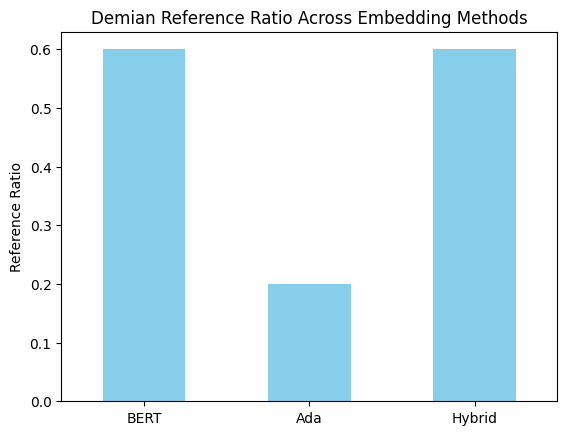

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 데미안 참조 비율 계산
reference_results = main()
df = pd.DataFrame.from_dict(reference_results, orient="index", columns=["Reference Ratio"])

# 표 출력
print(df)

# 그래프 생성
plt.figure(figsize=(8, 5))
df.plot(kind="bar", legend=False, color=["skyblue"])
plt.title("Demian Reference Ratio Across Embedding Methods")
plt.ylabel("Reference Ratio")
plt.xticks(rotation=0)
plt.show()


FAISS 인덱스를 /content/drive/My Drive/Colab Notebooks/faiss/bert_faiss.index에서 로드합니다.
FAISS 인덱스를 /content/drive/My Drive/Colab Notebooks/faiss/ada_faiss.index에서 로드합니다.
FAISS 인덱스를 /content/drive/My Drive/Colab Notebooks/faiss/hybrid_faiss.index에서 로드합니다.


<ipython-input-20-e605dc7c5a0c>:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(bert_similarities, label="BERT", shade=True, color='skyblue')
<ipython-input-20-e605dc7c5a0c>:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ada_similarities, label="Ada", shade=True, color='lightgreen')
<ipython-input-20-e605dc7c5a0c>:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(hybrid_similarities, label="Hybrid", shade=True, color='salmon')


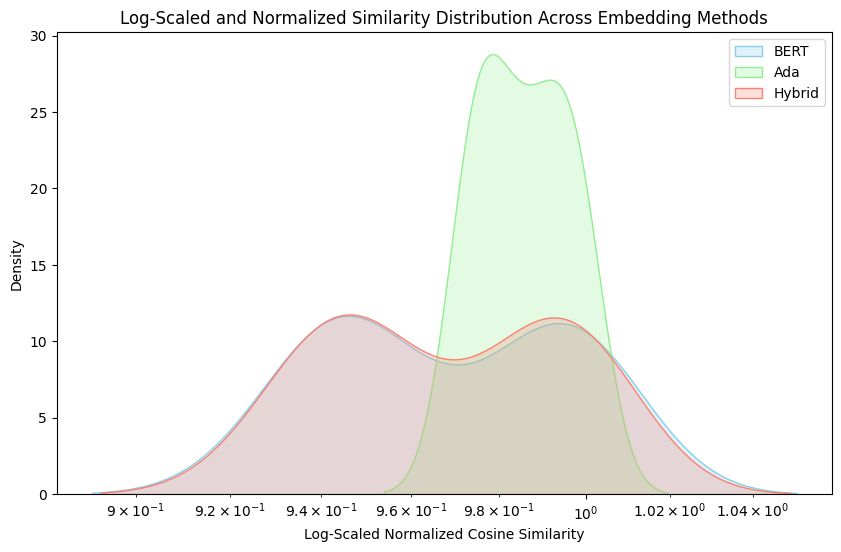

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def generate_similarity_distributions_top_k_normalized(query_text, bert_db, ada_db, hybrid_db, k=10):
    # BERT 유사도 계산
    bert_query = generate_bert_embedding(query_text)
    ada_query = generate_ada_embedding(query_text)
    hybrid_query = generate_hybrid_embedding(query_text, bert_weight=0.5, ada_weight=0.5)

    # 상위 k개의 유사도 값만 추출
    bert_distances, _ = bert_db.search(np.array([bert_query]).astype('float32'), k)
    ada_distances, _ = ada_db.search(np.array([ada_query]).astype('float32'), k)
    hybrid_distances, _ = hybrid_db.search(np.array([hybrid_query]).astype('float32'), k)

    # 코사인 유사도 계산
    bert_similarities = 1 / (1 + bert_distances.flatten())
    ada_similarities = 1 / (1 + ada_distances.flatten())
    hybrid_similarities = 1 / (1 + hybrid_distances.flatten())

    # 정규화
    bert_similarities /= np.max(bert_similarities)
    ada_similarities /= np.max(ada_similarities)
    hybrid_similarities /= np.max(hybrid_similarities)

    return bert_similarities, ada_similarities, hybrid_similarities

def plot_similarity_distributions_log_scale(bert_similarities, ada_similarities, hybrid_similarities):
    # 로그 스케일 시각화
    plt.figure(figsize=(10, 6))
    sns.kdeplot(bert_similarities, label="BERT", shade=True, color='skyblue')
    sns.kdeplot(ada_similarities, label="Ada", shade=True, color='lightgreen')
    sns.kdeplot(hybrid_similarities, label="Hybrid", shade=True, color='salmon')
    plt.title('Log-Scaled and Normalized Similarity Distribution Across Embedding Methods')
    plt.xscale('log')  # x축을 로그 스케일로 변환
    plt.xlabel('Log-Scaled Normalized Cosine Similarity')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Main 함수 내에서 호출
if __name__ == "__main__":
    # 테스트 쿼리: 유리알 유희
    query_text = "/content/drive/My Drive/Colab Notebooks/dataset/GlassBeadGame.pdf"

    # 기존 FAISS 인덱스 로드
    bert_db = load_faiss_index("/content/drive/My Drive/Colab Notebooks/faiss/bert_faiss.index")
    ada_db = load_faiss_index("/content/drive/My Drive/Colab Notebooks/faiss/ada_faiss.index")
    hybrid_db = load_faiss_index("/content/drive/My Drive/Colab Notebooks/faiss/hybrid_faiss.index")

    # 유사도 분포 생성
    bert_similarities, ada_similarities, hybrid_similarities = generate_similarity_distributions_top_k_normalized(
        query_text, bert_db, ada_db, hybrid_db, k=10
    )

    # 로그 스케일과 정규화된 그래프 출력
    plot_similarity_distributions_log_scale(bert_similarities, ada_similarities, hybrid_similarities)


##적분 값 차이 알아내기

FAISS 인덱스를 /content/bert_faiss.index에서 로드했습니다.
메타데이터를 /content/bert_metadata.json에서 로드했습니다.
FAISS 인덱스를 /content/ada_faiss.index에서 로드했습니다.
메타데이터를 /content/ada_metadata.json에서 로드했습니다.
FAISS 인덱스를 /content/hybrid_faiss.index에서 로드했습니다.
메타데이터를 /content/hybrid_metadata.json에서 로드했습니다.


<ipython-input-46-e3a9d6bc8523>:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(bert_similarities, label="BERT", shade=True, color='skyblue')
<ipython-input-46-e3a9d6bc8523>:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ada_similarities, label="Ada", shade=True, color='lightgreen')
<ipython-input-46-e3a9d6bc8523>:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(hybrid_similarities, label="Hybrid", shade=True, color='salmon')


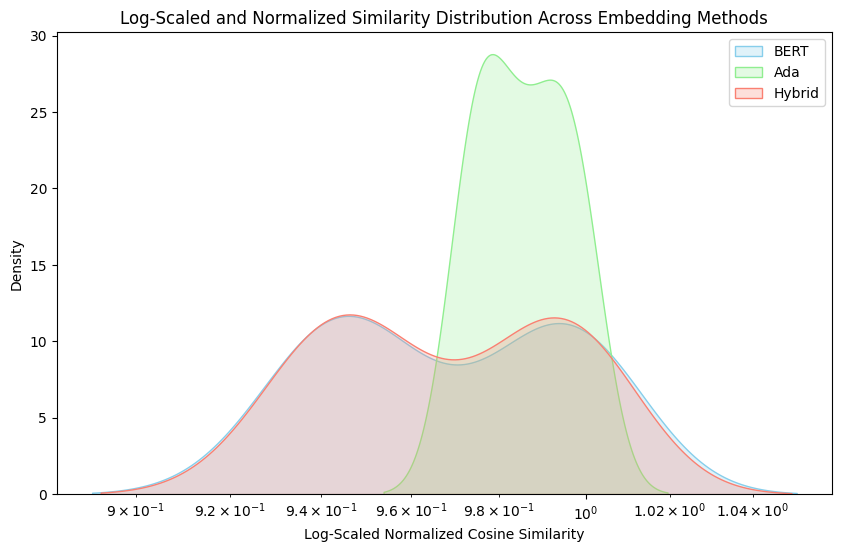

교점 x값: [0.96561562 1.00600601]
면적 차이 (Hybrid - BERT): 0.0133


<ipython-input-46-e3a9d6bc8523>:90: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  hybrid_area = simps(hybrid_density[mask], x[mask])
<ipython-input-46-e3a9d6bc8523>:91: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  bert_area = simps(bert_density[mask], x[mask])


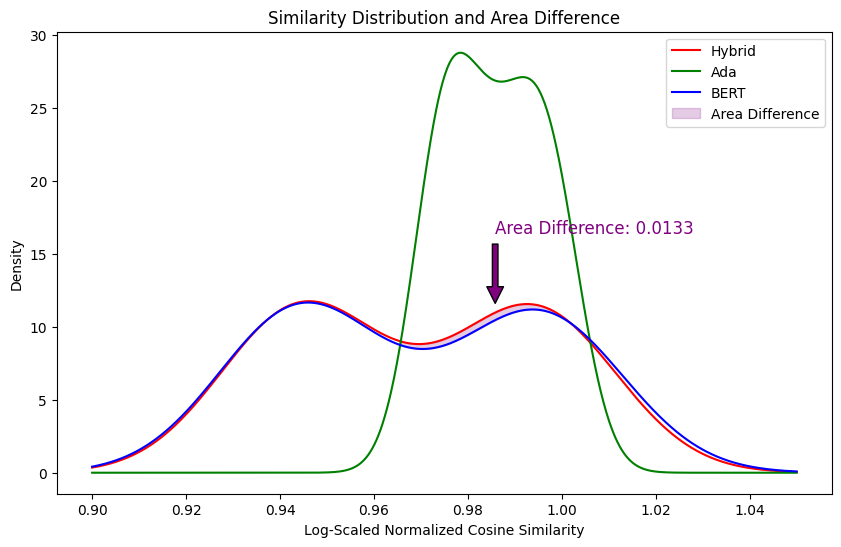

In [46]:
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

def generate_similarity_distributions_top_k_normalized(query_text, bert_db, ada_db, hybrid_db, k=10):
    # BERT 유사도 계산
    bert_query = generate_bert_embedding(query_text)
    ada_query = generate_ada_embedding(query_text)
    hybrid_query = generate_hybrid_embedding(query_text, bert_weight=0.5, ada_weight=0.5)

    # 상위 k개의 유사도 값만 추출
    bert_distances, _ = bert_db.search(np.array([bert_query]).astype('float32'), k)
    ada_distances, _ = ada_db.search(np.array([ada_query]).astype('float32'), k)
    hybrid_distances, _ = hybrid_db.search(np.array([hybrid_query]).astype('float32'), k)

    # 코사인 유사도 계산
    bert_similarities = 1 / (1 + bert_distances.flatten())
    ada_similarities = 1 / (1 + ada_distances.flatten())
    hybrid_similarities = 1 / (1 + hybrid_distances.flatten())

    # 정규화
    bert_similarities /= np.max(bert_similarities)
    ada_similarities /= np.max(ada_similarities)
    hybrid_similarities /= np.max(hybrid_similarities)

    return bert_similarities, ada_similarities, hybrid_similarities

def plot_similarity_distributions_log_scale(bert_similarities, ada_similarities, hybrid_similarities):
    # 로그 스케일 시각화
    plt.figure(figsize=(10, 6))
    sns.kdeplot(bert_similarities, label="BERT", shade=True, color='skyblue')
    sns.kdeplot(ada_similarities, label="Ada", shade=True, color='lightgreen')
    sns.kdeplot(hybrid_similarities, label="Hybrid", shade=True, color='salmon')
    plt.title('Log-Scaled and Normalized Similarity Distribution Across Embedding Methods')
    plt.xscale('log')  # x축을 로그 스케일로 변환
    plt.xlabel('Log-Scaled Normalized Cosine Similarity')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Main 함수 내에서 호출
if __name__ == "__main__":
    # 테스트 쿼리: 유리알 유희
    query_text = "/content/drive/My Drive/Colab Notebooks/dataset/GlassBeadGame.pdf"

     # 기존 FAISS 인덱스와 메타데이터 로드
    bert_db, bert_metadata_store = load_faiss_index_with_metadata(
        "/content/bert_faiss.index",
        "/content/bert_metadata.json"
    )
    ada_db, ada_metadata_store = load_faiss_index_with_metadata(
        "/content/ada_faiss.index",
        "/content/ada_metadata.json"
    )
    hybrid_db, hybrid_metadata_store = load_faiss_index_with_metadata(
        "/content/hybrid_faiss.index",
        "/content/hybrid_metadata.json"
    )

    # 유사도 분포 생성
    bert_similarities, ada_similarities, hybrid_similarities = generate_similarity_distributions_top_k_normalized(
        query_text, bert_db, ada_db, hybrid_db, k=10
    )

    # 로그 스케일과 정규화된 그래프 출력
    plot_similarity_distributions_log_scale(bert_similarities, ada_similarities, hybrid_similarities)


x = np.linspace(0.9, 1.05, 1000)  # x축 범위
hybrid_density = gaussian_kde(hybrid_similarities)(x)  # Hybrid 밀도
ada_density = gaussian_kde(ada_similarities)(x)        # Ada 밀도
bert_density = gaussian_kde(bert_similarities)(x)      # BERT 밀도

# 교점 계산 (Hybrid와 Ada)
density_diff = hybrid_density - ada_density
cross_points = np.where(np.diff(np.sign(density_diff)))[0]  # 부호가 바뀌는 지점
cross_x = x[cross_points]
print("교점 x값:", cross_x)

from scipy.integrate import simps

# 교점 사이의 범위 추출
start_x, end_x = cross_x[0], cross_x[1]
mask = (x >= start_x) & (x <= end_x)

# 정적분 계산
hybrid_area = simps(hybrid_density[mask], x[mask])
bert_area = simps(bert_density[mask], x[mask])

# 면적 차이 계산
area_difference = hybrid_area - bert_area
print(f"면적 차이 (Hybrid - BERT): {area_difference:.4f}")

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(x, hybrid_density, label="Hybrid", color="red")
plt.plot(x, ada_density, label="Ada", color="green")
plt.plot(x, bert_density, label="BERT", color="blue")

# 보라색 영역 표시
if len(cross_x) >= 2:
    plt.fill_between(x[mask], hybrid_density[mask], bert_density[mask], color="purple", alpha=0.2, label="Area Difference")

    # 화살표와 텍스트 추가
    middle_x = (start_x + end_x) / 2  # 화살표의 x 위치 (중간값)
    middle_y = (hybrid_density + bert_density)[mask].max() / 2  # 화살표의 y 위치 (중간값)
    plt.annotate(
        f"Area Difference: {area_difference:.4f}",
        xy=(middle_x, middle_y),
        xytext=(middle_x, middle_y + 5),  # 화살표의 끝 위치
        arrowprops=dict(facecolor='purple', shrink=0.05),
        fontsize=12,
        color="purple"
    )

# 그래프 꾸미기
plt.title("Similarity Distribution and Area Difference")
plt.xlabel("Log-Scaled Normalized Cosine Similarity")
plt.ylabel("Density")
plt.legend()
plt.show()


In [47]:
total_hybrid_area = simps(hybrid_density, x)
total_bert_area = simps(bert_density, x)

relative_difference = (area_difference / total_hybrid_area) * 100
print(f"면적 차이 (Hybrid - BERT) 비율: {relative_difference:.2f}%")


면적 차이 (Hybrid - BERT) 비율: 1.33%


<ipython-input-47-4c67eb9dd71e>:1: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  total_hybrid_area = simps(hybrid_density, x)
<ipython-input-47-4c67eb9dd71e>:2: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  total_bert_area = simps(bert_density, x)
